# **HOMEWORK 1**
Build a classifier for fashion MNIST.

**1. Use exactly the same architectures (both densely connected layers and from convolutional layers) as the above MNIST** e.g., replace the dataset. Save the Jupyter Notebook in its original format and output a PDF file after training, testing, and validation. Make sure to write down how do they perform (training accuracny, testing accuracy).  
**2. Improve the architecture**. Experiment with different numbers of layers, size of layers, number of filters, size of filters. You are required to make those adjustment to get the highest accuracy. Watch out for overfitting -- we want the highest testing accuracy!
Please provide a PDF file of the result, the best test accuracy and the architecture (different numbers of layers, size of layers, number of filters, size of filters)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from datetime import datetime

import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
%matplotlib inline

from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torch.autograd import Variable

from PIL import Image

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data exploration

In [3]:
# Load the dataset
fashion_dataset = FashionMNIST(root='./data', download=True, train = True, transform = transforms.ToTensor())
print(fashion_dataset)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.00MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.66MB/s]


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([1, 28, 28]) 0
tensor([[[0.6510, 0.5961, 0.6196, 0.6196, 0.6275],
         [0.6235, 0.6000, 0.6157, 0.6196, 0.6353],
         [0.6196, 0.6078, 0.6353, 0.6196, 0.6275],
         [0.5961, 0.6275, 0.6196, 0.6314, 0.6275],
         [0.5765, 0.6431, 0.6078, 0.6471, 0.6314]]])
tensor(1.) tensor(0.)


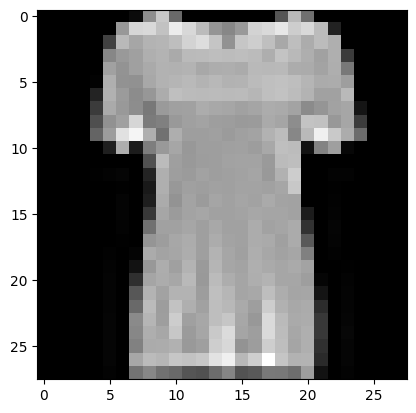

In [4]:
sampleTensor, label = fashion_dataset[10]
print(sampleTensor.shape, label)
tpil = transforms.ToPILImage() # using the __call__ to
image = tpil(sampleTensor)
image.show()

# The values range from 0 to 1, with 0 representing black, 1 white and the values between different shades of grey.
print(sampleTensor[:,10:15,10:15])
print(torch.max(sampleTensor), torch.min(sampleTensor))

plt.imshow(sampleTensor[0,:,:], cmap = 'gray')

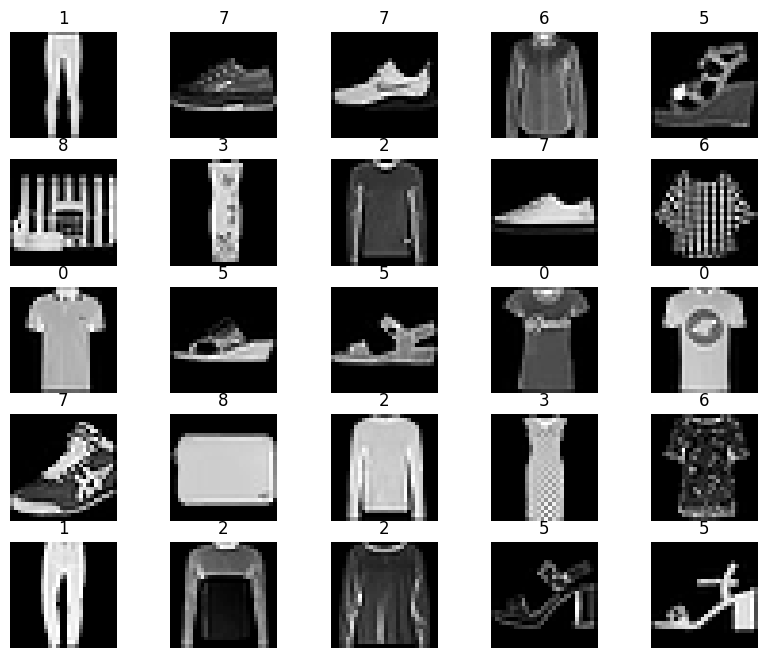

In [5]:
# Print multiple images at once
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(fashion_dataset), size=(1,)).item()
    img, label = fashion_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Training, validation and test datasets

In [6]:
train_data, validation_data = random_split(fashion_dataset, [50000, 10000])
test_data = FashionMNIST(root = 'data/', train = False, transform = transforms.ToTensor())

# Print the length of train and validation datasets
print("length of Train Dataset: ", len(train_data))
print("length of Validation Dataset: ", len(validation_data))
print("length of Test Dataset: ", len(test_data))

batch_size = 128
train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size, shuffle = False)

length of Train Dataset:  50000
length of Validation Dataset:  10000
length of Test Dataset:  10000


# FC model

In [7]:
input_size = 28 * 28
num_classes = 10

class FashionMnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return(out)

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images) # generate predictions
        loss = F.cross_entropy(out, labels) # calculate the loss
        return(loss)

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        out = self(images) # generate predictions
        loss = F.cross_entropy(out, labels) # calculate the loss
        acc = accuracy(out, labels) # calculate metrics/accuracy
        return({'val_loss':loss, 'val_acc': acc})

    def validation_epoch_end(self, outputs):
        # at the end of epoch (after running through all the batches)
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})

    def epoch_end(self, epoch,result):
        # log epoch, loss, metrics
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

def evaluate(model, data_loader):
    # for batch in data_loader, run validation_step
    outputs = [model.validation_step(batch) for batch in data_loader]
    return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):

        ## Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward() ## backpropagation starts at the loss and goes through all layers to model inputs
            optimizer.step() ## the optimizer iterate over all parameters (tensors); use their stored grad to update their values
            optimizer.zero_grad() ## reset gradients

        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

In [8]:
set_seed(42)
model = FashionMnistModel().to(device)

In [9]:
# Train for 15 epochs
history = fit(15, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.7178, val_acc: 0.6128
Epoch [1], val_loss: 1.4284, val_acc: 0.6477
Epoch [2], val_loss: 1.2619, val_acc: 0.6606
Epoch [3], val_loss: 1.1549, val_acc: 0.6702
Epoch [4], val_loss: 1.0800, val_acc: 0.6790
Epoch [5], val_loss: 1.0242, val_acc: 0.6903
Epoch [6], val_loss: 0.9805, val_acc: 0.6975
Epoch [7], val_loss: 0.9456, val_acc: 0.7077
Epoch [8], val_loss: 0.9164, val_acc: 0.7148
Epoch [9], val_loss: 0.8919, val_acc: 0.7230
Epoch [10], val_loss: 0.8708, val_acc: 0.7272
Epoch [11], val_loss: 0.8521, val_acc: 0.7317
Epoch [12], val_loss: 0.8357, val_acc: 0.7366
Epoch [13], val_loss: 0.8210, val_acc: 0.7433
Epoch [14], val_loss: 0.8076, val_acc: 0.7467


Text(0.5, 1.0, 'Accuracy over epochs')

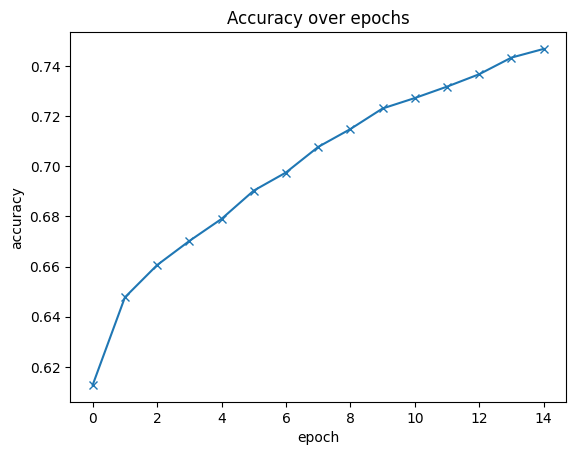

In [10]:
# Plot accuracy
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

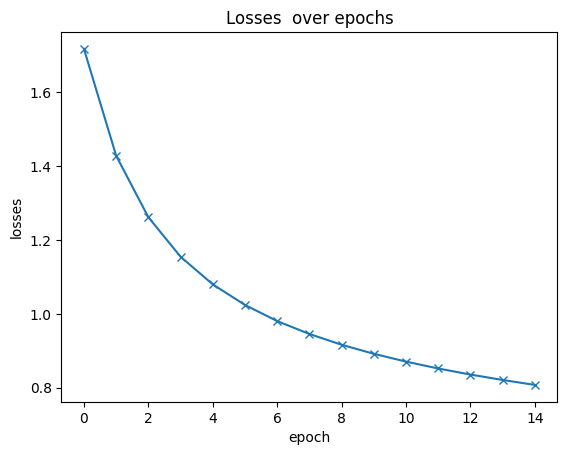

In [11]:
# Plot losses
losses = [result['val_loss'] for result in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

## Performance on the test dataset

In [12]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return(preds[0].item())

In [13]:
img, label = test_data[0]
print('Label:', label, ', Predicted :', predict_image(img, model))

Label: 9 , Predicted : 9


In [14]:
# Final check on the test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.8159030079841614, 'val_acc': 0.7366495132446289}

# Convolutional Neural Network model

In [15]:
class FashionMnistCNN(nn.Module):
    def __init__(self):
        super(FashionMnistCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x  # return x for visualization

In [16]:
def train(num_epochs, cnn, train_loader, val_loader):
    history = []
    optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
    loss_func = nn.CrossEntropyLoss()
    total_step = len(train_loader)  # train the model

    for epoch in range(num_epochs):

        ## Training phase
        cnn.train()
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

        ## Validation phase
        cnn.eval()
        total_correct = 0
        total_images = 0
        total_loss = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                images, labels = images.to(device), labels.to(device)
                b_x = Variable(images)   # batch x
                b_y = Variable(labels)   # batch y
                outputs = cnn(b_x)[0]
                _, preds = torch.max(outputs, dim = 1)
                total_correct += torch.sum(preds == labels).item()
                total_images += labels.size(0)
                total_loss += loss_func(outputs, b_y).item()

            val_acc = total_correct / total_images
            val_loss = total_loss / len(val_loader)

        print(f'Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')
        history.append({'val_loss': val_loss, 'val_acc': val_acc})

    return(history)

In [17]:
set_seed(42)
cnn = FashionMnistCNN().to(device)
history_cnn = train(num_epochs=5, cnn=cnn, train_loader=train_loader, val_loader=val_loader)

Epoch [1/5], Step [100/391], Loss: 0.5360
Epoch [1/5], Step [200/391], Loss: 0.3610
Epoch [1/5], Step [300/391], Loss: 0.5668
Validation loss: 0.3271, Validation accuracy: 0.8815
Epoch [2/5], Step [100/391], Loss: 0.2738
Epoch [2/5], Step [200/391], Loss: 0.4752
Epoch [2/5], Step [300/391], Loss: 0.1804
Validation loss: 0.2974, Validation accuracy: 0.8916
Epoch [3/5], Step [100/391], Loss: 0.2546
Epoch [3/5], Step [200/391], Loss: 0.2213
Epoch [3/5], Step [300/391], Loss: 0.2940
Validation loss: 0.3214, Validation accuracy: 0.8842
Epoch [4/5], Step [100/391], Loss: 0.1700
Epoch [4/5], Step [200/391], Loss: 0.2829
Epoch [4/5], Step [300/391], Loss: 0.3904
Validation loss: 0.3070, Validation accuracy: 0.8919
Epoch [5/5], Step [100/391], Loss: 0.3660
Epoch [5/5], Step [200/391], Loss: 0.2869
Epoch [5/5], Step [300/391], Loss: 0.3182
Validation loss: 0.2761, Validation accuracy: 0.8995


Text(0.5, 1.0, 'Accuracy over epochs')

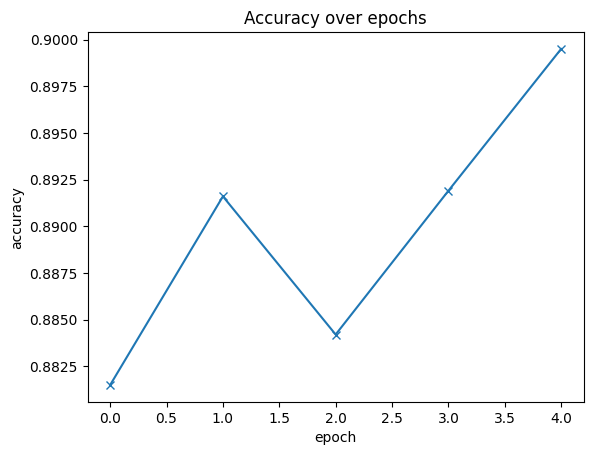

In [18]:
# Plot accuracy
accuracies = [result['val_acc'] for result in history_cnn]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

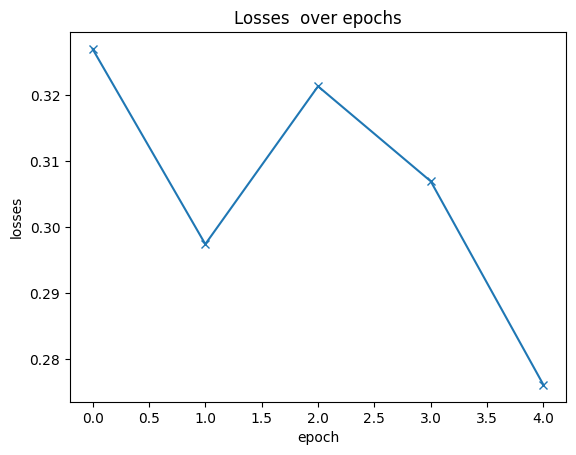

In [19]:
# Plot losses
losses = [result['val_loss'] for result in history_cnn]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

## Evaluate the model on test data

In [20]:
# Test the model, after the training
cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output, last_layer = cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)


Test Accuracy of the model on the 10000 test images: 0.88


# Improved CNN model

In [64]:
class NewFashionMnistCNN(nn.Module):
    def __init__(self):
        super(NewFashionMnistCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)  # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

In [65]:
set_seed(42)
new_cnn = NewFashionMnistCNN().to(device)
history_new_cnn = train(num_epochs=5, cnn=new_cnn, train_loader=train_loader, val_loader=val_loader)

Epoch [1/5], Step [100/391], Loss: 0.4222
Epoch [1/5], Step [200/391], Loss: 0.4579
Epoch [1/5], Step [300/391], Loss: 0.3500
Validation loss: 0.3453, Validation accuracy: 0.8742
Epoch [2/5], Step [100/391], Loss: 0.2640
Epoch [2/5], Step [200/391], Loss: 0.3243
Epoch [2/5], Step [300/391], Loss: 0.3377
Validation loss: 0.3350, Validation accuracy: 0.8818
Epoch [3/5], Step [100/391], Loss: 0.2433
Epoch [3/5], Step [200/391], Loss: 0.2217
Epoch [3/5], Step [300/391], Loss: 0.2988
Validation loss: 0.3106, Validation accuracy: 0.8886
Epoch [4/5], Step [100/391], Loss: 0.3326
Epoch [4/5], Step [200/391], Loss: 0.2032
Epoch [4/5], Step [300/391], Loss: 0.2756
Validation loss: 0.3268, Validation accuracy: 0.8836
Epoch [5/5], Step [100/391], Loss: 0.1371
Epoch [5/5], Step [200/391], Loss: 0.2888
Epoch [5/5], Step [300/391], Loss: 0.2759
Validation loss: 0.3090, Validation accuracy: 0.8955


Text(0.5, 1.0, 'Accuracy over epochs')

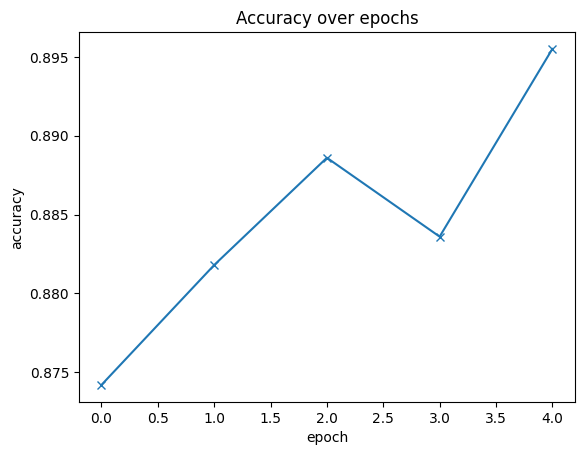

In [69]:
# Plot accuracy
accuracies = [result['val_acc'] for result in history_new_cnn]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy over epochs')

Text(0.5, 1.0, 'Losses  over epochs')

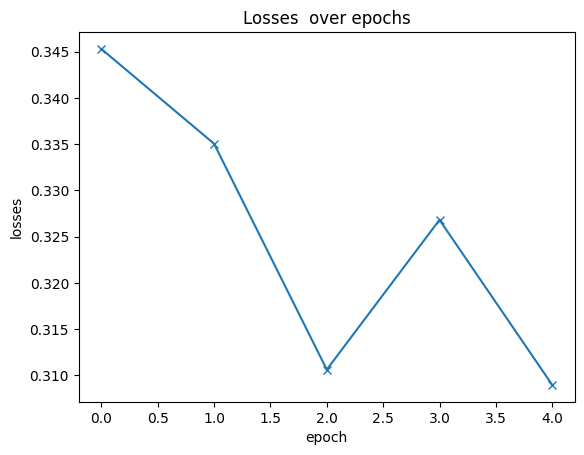

In [70]:
# Plot losses
losses = [result['val_loss'] for result in history_new_cnn]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('Losses  over epochs')

## Evaluate on the test data

In [66]:
# Test the model, after the training
new_cnn.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        test_output, last_layer = new_cnn(images)
        pred_y = torch.max(test_output, 1)[1].data.squeeze()
        accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
        pass
print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

Test Accuracy of the model on the 10000 test images: 0.94
